### Deutsch-Jozsa Algorithm

in Qiskit

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_ibm_runtime import Sampler, QiskitRuntimeService
from qiskit_aer import Aer
import numpy as np
from copy import deepcopy

%matplotlib inline

#### Define initial values and building blocks for our circuits

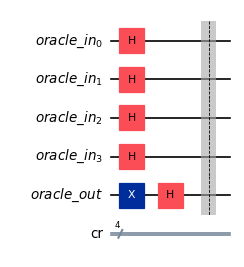

In [19]:
# number of qubits used in the oracle
n = 4 

oracle_in = QuantumRegister(n, "oracle_in")          # oracle qubits
oracle_out = QuantumRegister(1, "oracle_out")        # qubit for oracle output
cr = ClassicalRegister(n, "cr")                      # for measurement

qc_start = QuantumCircuit(oracle_in, oracle_out, cr)

# apply H to all the oracle gates
for i in range(n):
    qc_start.h(oracle_in[i])

# apply X and H to the output qubit
qc_start.x(oracle_out) 
qc_start.h(oracle_out)

qc_start.barrier()     # visualization barrier

qc_start.draw("mpl", scale=0.6);

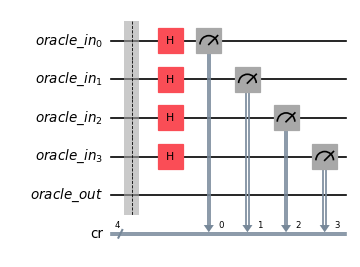

In [20]:
# Lets define the second part of the circuit as a separate one, to test both 
# constant and balanced function

qc_end = QuantumCircuit(oracle_in, oracle_out, cr)

qc_end.barrier()

for i in range(n):
    qc_end.h(oracle_in[i])

qc_end.measure(oracle_in, cr)

qc_end.draw("mpl", scale=0.6);

Now we define two oracles, for a constant and balanced functions, respectively

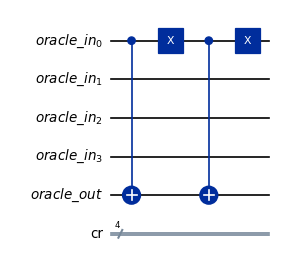

In [21]:
# oracle for a function that always returns 1
const = QuantumCircuit(oracle_in, oracle_out, cr)
const.cx(oracle_in[0], oracle_out)
const.x(oracle_in[0])
const.cx(oracle_in[0], oracle_out)
const.x(oracle_in[0])

const.draw("mpl", scale=0.6);

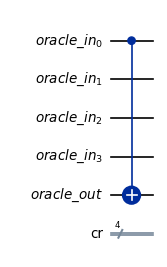

In [22]:
# oracle for a function that always returns 1
balance = QuantumCircuit(oracle_in, oracle_out, cr)
balance.cx(oracle_in[0], oracle_out)

balance.draw("mpl", scale=0.6);

#### Circuit with an oracle being a constant function

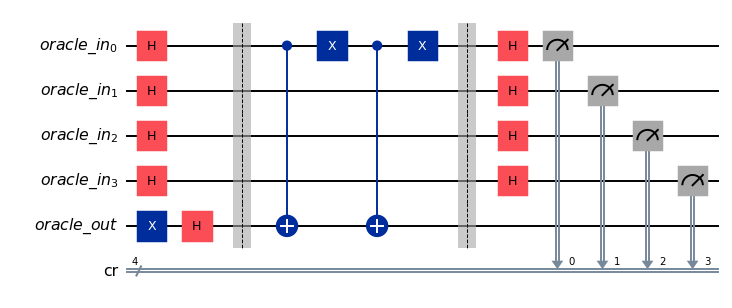

In [23]:
# we compose the circuit
qc_const = deepcopy(qc_start)

qc_const.compose(const, inplace=True)
qc_const.compose(qc_end, inplace=True)

qc_const.draw("mpl", scale=0.7);

In [24]:
# and run it with a simulator
backend = Aer.get_backend("qasm_simulator")
job = backend.run(qc_const, shots=100)
counts = job.result().get_counts()

print(counts)

{'0000': 100}


#### Circuit with an oracle being a balanced function

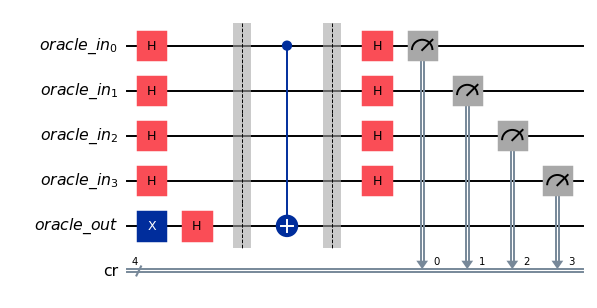

In [32]:
# we compose the circuit
qc_bal = QuantumCircuit(oracle_in, oracle_out, cr)

qc_bal.compose(qc_start, inplace=True)
qc_bal.compose(balance, inplace=True)
qc_bal.compose(qc_end, inplace=True)

qc_bal.draw("mpl", scale=0.7);

In [29]:
# and run it with a simulator
backend = Aer.get_backend("qasm_simulator")
job = backend.run(qc_bal, shots=100)
counts = job.result().get_counts()

print(counts)

{'0001': 100}


#### And on a quantum hardware

In [ ]:
# and run it with a simulator
service = QiskitRuntimeService(channel="ibm_quantum_platform")
backend = service.least_busy()
print(f"Least busy backend: {backend.name}")
print(f"Has {backend.status().pending_jobs} pending jobs.")

comp_qc_const = transpile(qc_const, backend)
comp_qc_bal = transpile(qc_bal, backend)
sampler = Sampler(backend)
job_const = sampler.run([comp_qc_const])
job_bal = sampler.run([comp_qc_bal])

qiskit_runtime_service.__init__:WARNING:2025-11-04 20:37:51,597: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: eloza. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-04 20:37:51,998: Using instance: eloza, plan: open


Least busy backend: ibm_fez
Has 109 pending jobs.


In [40]:
res_const = job_const.result()
counts_const = res_const[0].data.cr.get_counts()
print("Results for the constant function:")
print(counts_const)

print("-" * 125)

res_bal = job_bal.result()
counts_bal = res_bal[0].data.cr.get_counts()
print("Results for the balanced function:")
print(counts_bal)

Results for the constant function:
{'0000': 4049, '0001': 16, '0100': 18, '1000': 8, '0010': 5}
-----------------------------------------------------------------------------------------------------------------------------
Results for the balanced function:
{'0001': 3876, '0101': 42, '0000': 92, '0011': 53, '1001': 28, '0100': 1, '1101': 1, '0010': 1, '0111': 1, '1011': 1}


In [41]:
service = QiskitRuntimeService(channel="ibm_quantum_platform")
backend = service.least_busy()
print(type(backend))
print(f"Least busy backend: {backend.name}")
print(f"Has {backend.status().pending_jobs} pending jobs.")

qiskit_runtime_service.__init__:WARNING:2025-11-05 14:41:37,516: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: eloza. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-05 14:41:38,093: Using instance: eloza, plan: open


<class 'qiskit_ibm_runtime.ibm_backend.IBMBackend'>
Least busy backend: ibm_fez
Has 126 pending jobs.


In [42]:
print(type(job_const))

<class 'qiskit_ibm_runtime.runtime_job_v2.RuntimeJobV2'>
